### hw_03: Ground Filtering

#### Exploratory analysis of example datasets and results.

In [1]:
import os
import glob

import math
import numpy as np
from laspy.file import File
import pandas as pd
#import geopandas as gpd
#from shapely.geometry import Point

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns

from osgeo import gdal

#### rural.las

In [2]:
#Read LAS file
inFile = File("./ahn3/rural.las", mode = "r")

In [3]:
print('Examining Point Format: ')
pointformat = inFile.point_format
for spec in inFile.point_format:
    print(spec.name)

Examining Point Format: 
X
Y
Z
intensity
flag_byte
raw_classification
scan_angle_rank
user_data
pt_src_id
gps_time
red
green
blue


In [4]:
#Import LAS into numpy array 
lidar_points = np.array((inFile.x, inFile.y, inFile.z, inFile.intensity,
                         inFile.raw_classification, inFile.scan_angle_rank,
                         inFile.red, inFile.green, inFile.blue)).transpose() # inFile.return_number,

#colors = np.vstack((inFile.red, inFile.green, inFile.blue)).transpose()
print(len(lidar_points))

1716621


In [6]:
#Transform to pandas DataFrame
lidar_df = pd.DataFrame(lidar_points, columns=['x', 'y', 'z', 'intensity', 'class', 
                                          'scan_angle', 'red', 'green', 'blue'])

In [7]:
lidar_df.describe()

,x,y,z,intensity,class,scan_angle,red,green,blue
count,1.716621e+06,1.716621e+06,1.716621e+06,1.716621e+06,1716621.0,1.716621e+06,1716621.0,1716621.0,1716621.0
mean,1.984804e+05,4.483902e+05,5.677698e+01,1.029697e+02,0.0,-1.329126e+01,0.0,0.0,0.0
std,9.147255e+01,7.226156e+01,1.222225e+01,8.618814e+01,0.0,1.255784e+01,0.0,0.0,0.0
min,1.983066e+05,4.482716e+05,3.713000e+01,1.000000e+00,0.0,-3.300000e+01,0.0,0.0,0.0
25%,1.984064e+05,4.483287e+05,4.507000e+01,2.800000e+01,0.0,-2.300000e+01,0.0,0.0,0.0
50%,1.984959e+05,4.483855e+05,5.700000e+01,7.500000e+01,0.0,-1.700000e+01,0.0,0.0,0.0
75%,1.985610e+05,4.484472e+05,6.575000e+01,1.640000e+02,0.0,-5.000000e+00,0.0,0.0,0.0
max,1.986121e+05,4.485337e+05,8.871000e+01,6.570000e+02,0.0,3.100000e+01,0.0,0.0,0.0


In [8]:
print('diff x:', lidar_df.x.min() - lidar_df.x.max())
print('diff y:', lidar_df.y.min() - lidar_df.y.max())
print('diff z:', lidar_df.z.min() - lidar_df.z.max())

diff x: -305.52999999999884
diff y: -262.1500000000233
diff z: -51.58


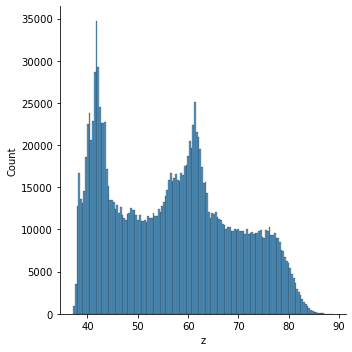

In [11]:
sns.displot(lidar_df.z)
plt.show()

In [23]:
factor=20
decimated_points_random = lidar_df[::factor]
print(len(decimated_points_random))

85832


In [14]:
extent = x_min, x_max, y_min, y_max = [lidar_df.x.min()-50, 
                                       lidar_df.x.max()+50,
                                       lidar_df.y.min()-50, 
                                       lidar_df.y.max()+50]

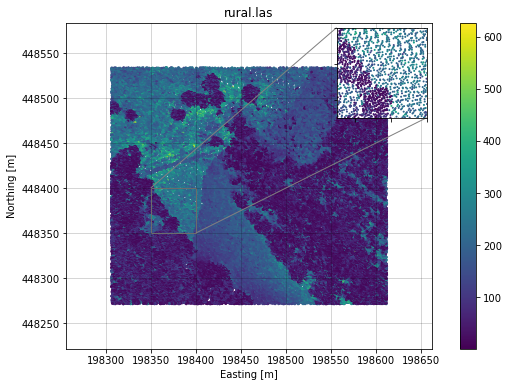

In [21]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

fig, ax = plt.subplots(figsize=(10,6))

cm = ax.scatter(decimated_points_random.x, decimated_points_random.y, 
                #c=decimated_points_random.z,
                c=decimated_points_random.intensity, 
                #c=decimated_points_random.scan_angle,
                s=4)
ax.set_aspect(1)
ax.set_xlim(*extent[:2])
ax.set_ylim(*extent[2:])
ax.set_xlabel('Easting [m]')
ax.set_ylabel('Northing [m]')
ax.set_title('rural.las')
ax.grid(c='k', alpha=0.2)
fig.colorbar(cm)

axins = zoomed_inset_axes(ax, 2, loc=1)
axins.scatter((decimated_points_random.x), (decimated_points_random.y), 
              #c=decimated_points_random.z,
              c=(decimated_points_random.intensity),
              #c=(decimated_points_random.scan_angle),
              s=1)
axins.set_xlim(198350, 198400)
axins.set_ylim(448350, 448400)
plt.xticks(visible=False)
plt.yticks(visible=False)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

plt.show()

**notice: `intensity` as the dependent variable instead of `z`**

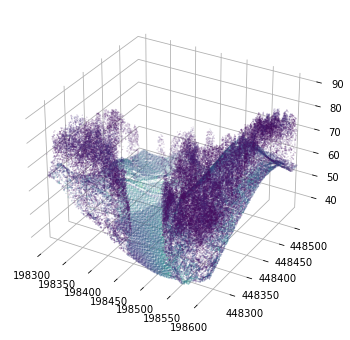

In [146]:

fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection='3d')

# Get rid of the panes                          
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0)) 
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0)) 
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0)) 

# Get rid of the spines                         
ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0)) 
ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0)) 
ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

ax.scatter(decimated_points_random.x, decimated_points_random.y, decimated_points_random.z, 
           c = decimated_points_random.intensity, #z, 
           s=0.02)
plt.show()

#### result

In [4]:
files = glob.glob(os.path.join('./result_r/*.asc'))
img_l = []
char2 = '.asc'
for file in files:
    ds = gdal.Open(file)#.ReadAsArray()
    array = ds.ReadAsArray()
    nan_array = array
    nan_array[array == -9999] = np.nan
    img_l.append(nan_array)
print(files)

['./result_r\\ruralOut-idw.asc', './result_r\\ruralOut-tin.asc', './result_r\\rural_dsm.asc']


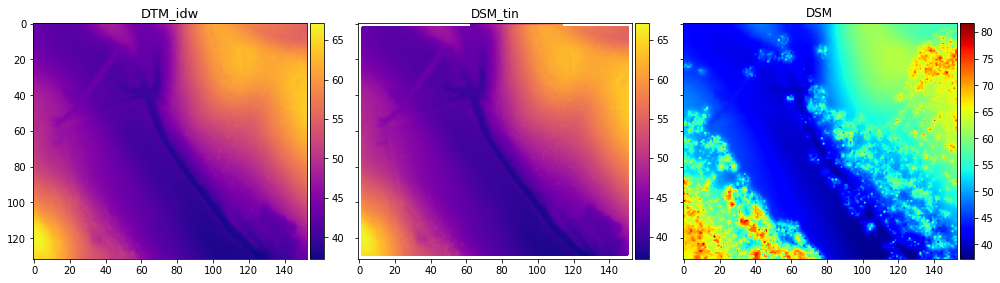

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(14,6), sharey=True)

ax = plt.subplot(131)
cb = plt.imshow(img_l[0], cmap=plt.cm.plasma)
ax.set_title('DTM_idw', fontdict={'fontsize': 13, 'fontweight': 'medium'})
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cb, cax=cax)
#plt.colorbar()

# 
ax = plt.subplot(132)
cd = plt.imshow(img_l[1], cmap=plt.cm.plasma)
ax.set_title('DSM_tin', fontdict={'fontsize': 12, 'fontweight': 'medium'})
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cd, cax=cax)
#plt.colorbar()

# 
ax = plt.subplot(133)
cf = plt.imshow(img_l[2], cmap=plt.cm.jet)
ax.set_title('DSM', fontdict={'fontsize': 12, 'fontweight': 'medium'})
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cf, cax=cax)
#plt.colorbar()

fig.tight_layout()
plt.show()

#### urban

In [88]:
#Read LAS file
inFile = File("./ahn3/urban.las", mode = "r")

In [89]:
#Import LAS into numpy array (X=raw integer value x=scaled float value)
lidar_points = np.array((inFile.x, inFile.y, inFile.z, inFile.intensity,
                         inFile.raw_classification, inFile.scan_angle_rank,
                         inFile.red, inFile.green, inFile.blue)).transpose() # inFile.return_number,

#colors = np.vstack((inFile.red, inFile.green, inFile.blue)).transpose()
print(len(lidar_points))

2074272


In [93]:
#Transform to pandas DataFrame
lidar_df = pd.DataFrame(lidar_points, columns=['x', 'y', 'z', 'intensity', 'class', 
                                          'scan_angle', 'red', 'green', 'blue'])
lidar_df.describe()

,x,y,z,intensity,class,scan_angle,red,green,blue
count,2.074272e+06,2.074272e+06,2.074272e+06,2.074272e+06,2074272.0,2.074272e+06,2074272.0,2074272.0,2074272.0
mean,9.167174e+04,4.382816e+05,4.162064e+00,1.347611e+02,0.0,-1.571894e+01,51200.0,11008.0,53248.0
std,1.337026e+02,7.016511e+01,5.882595e+00,1.557442e+02,0.0,9.676212e+00,0.0,0.0,0.0
min,9.144387e+04,4.381430e+05,-2.810000e+00,1.000000e+00,0.0,-3.400000e+01,51200.0,11008.0,53248.0
25%,9.155536e+04,4.382225e+05,-1.320000e+00,3.300000e+01,0.0,-2.400000e+01,51200.0,11008.0,53248.0
50%,9.166659e+04,4.382918e+05,2.640000e+00,1.110000e+02,0.0,-1.800000e+01,51200.0,11008.0,53248.0
75%,9.178563e+04,4.383437e+05,9.060000e+00,2.120000e+02,0.0,-7.000000e+00,51200.0,11008.0,53248.0
max,9.190305e+04,4.383875e+05,4.368000e+01,4.250200e+04,0.0,4.000000e+00,51200.0,11008.0,53248.0


In [94]:
print('diff x:', lidar_df.x.min() - lidar_df.x.max())
print('diff y:', lidar_df.y.min() - lidar_df.y.max())
print('diff z:', lidar_df.z.min() - lidar_df.z.max())

diff x: -459.18000000000757
diff y: -244.45999999996275
diff z: -46.49


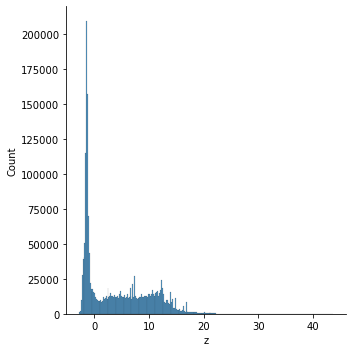

In [98]:
sns.displot(lidar_df.z)
plt.show()

In [99]:
factor=20
decimated_points_random = lidar_df[::factor]
#decimated_colors_random = colors[::factor]
print(len(decimated_points_random))

103714


In [102]:
extent = x_min, x_max, y_min, y_max = [lidar_df.x.min()-50, 
                                       lidar_df.x.max()+50,
                                       lidar_df.y.min()-50, 
                                       lidar_df.y.max()+50]

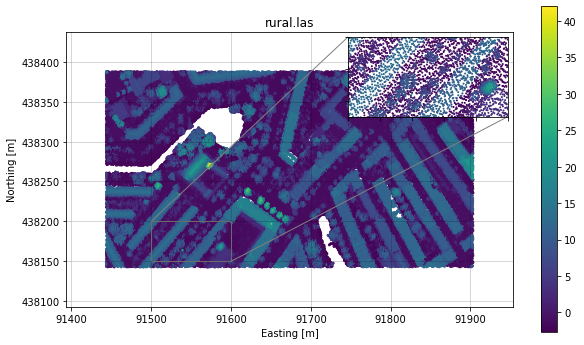

In [105]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

fig, ax = plt.subplots(figsize=(10,6))

cm = ax.scatter(decimated_points_random.x, decimated_points_random.y, 
                c=decimated_points_random.z,
                #c=decimated_points_random.intensity, 
                #c=decimated_points_random.scan_angle,
                s=4)
ax.set_aspect(1)
ax.set_xlim(*extent[:2])
ax.set_ylim(*extent[2:])
ax.set_xlabel('Easting [m]')
ax.set_ylabel('Northing [m]')
ax.set_title('rural.las')
ax.grid(c='k', alpha=0.2)
fig.colorbar(cm)

axins = zoomed_inset_axes(ax, 2, loc=1)
axins.scatter((decimated_points_random.x), (decimated_points_random.y), 
              c=decimated_points_random.z,
              #c=(decimated_points_random.intensity),
              #c=(decimated_points_random.scan_angle),
              s=1)
axins.set_xlim(91500, 91600)
axins.set_ylim(438150, 438200)
plt.xticks(visible=False)
plt.yticks(visible=False)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

plt.show()

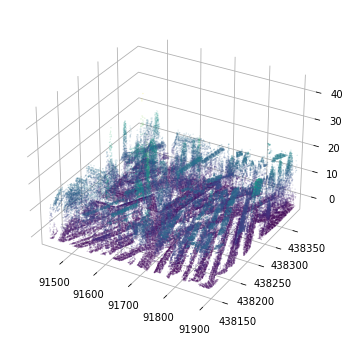

In [107]:
fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection='3d')

# Get rid of the panes                          
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0)) 
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0)) 
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0)) 

# Get rid of the spines                         
ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0)) 
ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0)) 
ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

ax.scatter(decimated_points_random.x, decimated_points_random.y, decimated_points_random.z, 
           c = decimated_points_random.z, #z, 
           s=0.02)
plt.show()

In [2]:
files = glob.glob(os.path.join('./result_u/*.asc'))
img_l = []
char2 = '.asc'
for file in files:
    ds = gdal.Open(file)#.ReadAsArray()
    array = ds.ReadAsArray()
    nan_array = array
    nan_array[array == -9999] = np.nan
    img_l.append(nan_array)
print(files)

['./result_u\\urbanOut-idw.asc', './result_u\\urbanOut-tin.asc', './result_u\\urban_dsm.asc']


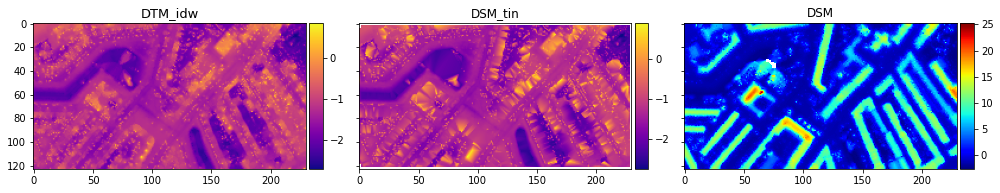

In [3]:
fig, ax = plt.subplots(1, 3, figsize=(14,6), sharey=True)

ax = plt.subplot(131)
cb = plt.imshow(img_l[0], cmap=plt.cm.plasma)
ax.set_title('DTM_idw', fontdict={'fontsize': 13, 'fontweight': 'medium'})
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cb, cax=cax)
#plt.colorbar()

# 
ax = plt.subplot(132)
cd = plt.imshow(img_l[1], cmap=plt.cm.plasma)
ax.set_title('DSM_tin', fontdict={'fontsize': 12, 'fontweight': 'medium'})
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cd, cax=cax)
#plt.colorbar()

# 
ax = plt.subplot(133)
cf = plt.imshow(img_l[2], cmap=plt.cm.jet)
ax.set_title('DSM', fontdict={'fontsize': 12, 'fontweight': 'medium'})
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cf, cax=cax)
#plt.colorbar()

fig.tight_layout()
plt.show()

*note the hole (white area - water) in the DSM ~ which the built-in `pdal` `writers.gdal` `type:idw` did not interpolate. This is possibly due to the `radius` and `window_size`*. **The DTM_idw does not accept a radius but the number of neighbours.**